# **Extended Project 3: Unsurpervised Learning**

Course: Computation Machine Learning I

Submitted: Dec 19, 2021

Student: Mathias Schindler

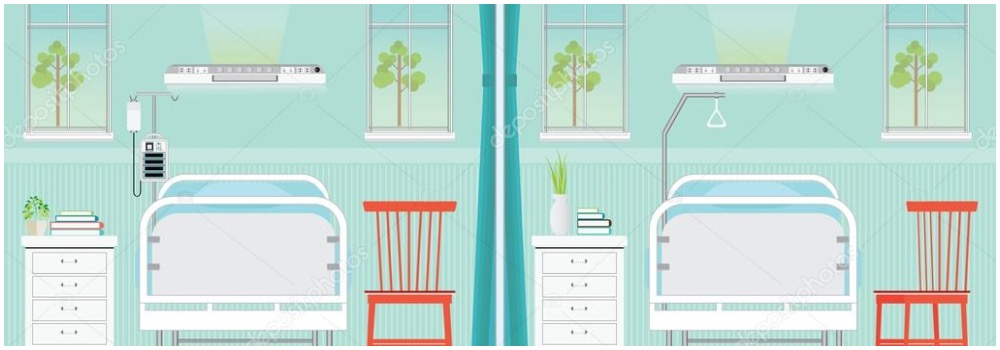

# 0.0 Instructions

## 0.0.1 Description

In this project, you have to cluster patients that enter an ICU (Intensive Care Unit) by the features that are known on the very first day. At the end, we will check if these groups of patients have similar outcome results, in terms of length of stay or probability of death.

The dataset comes from MIMIC project (https://mimic.physionet.org/). MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

Each row of *mimic_unsupervised_features.csv* correponds to one ICU stay (*hadm_id*+*icustay_id*) of one patient (*subject_id*). Most columns correspond to vitals of each patient (when entering the ICU), plus some general characteristics (age, gender, etc.), and their explanation can be found at *mimic_patient_metadata.csv*. 



Note that the main cause/disease of patient contidition is embedded as a code at *ICD9_diagnosis* column. The meaning of this code can be found at *MIMIC_metadata_diagnose.csv*. **But** this is only the main one; a patient can have co-occurrent diseases (comorbidities). These secondary codes can be found at *extra_data/MIMIC_diagnoses.csv*.

Additionally, the file *mimic_unsupervised_response.csv* contains the outcome of the patients visit to the ICU, did they die and how many days were they in the ICU for. We will use this to evaluate the clusters we produce.


Main tasks are:
+ Using *mimic_unsupervised_features.csv* file to cluster patient stays .
+ Using *mimic_unsupervised_response.csv*, check if resulting clusters are related to outcomes of patients, such as length of stay, mortality or assigned ICU.

## 0.0.2 Instructions

You can follow these **steps** for your implementation:
1. *Explore* and understand the dataset. 
2. For your *first* implmentation

   i). ~~Remove all non numeric columns (e.g ID's, dates and categories)~~<br />
   ii). ~~Standardise the data to have 0 column means and variance 1~~<br />
   iii). ~~Cluster the data using K-means. Show how you decided how many clusters to use~~<br />
   or<br />
   Cluster the data using spectral clustering. Show how you decided how many clusters to use<br />
3. ~~Then use the ~ingle valued decomposition (SVD) to reduce the dimensionality of the numerical feature space. Show how you decided how many dimensions to use. See how this affects your clustering~~<br />

4. Manage the date variables e.g. try to create an Age variable, and manage categorial features e.g. create *dummy variables* for relevant categorical features.  See how this affects your clustering

5. Consider how to incorporate the comorbidity information.

6. Explore relationship between clusters and outcomes of patients

Feel free to reduce the dataset if you experience computational constraints.
As a *bonus*, explore if adding as an input feature the cluster label would improve a prediction model of mortality (e.g. try with LogisticRegression, or any non-linear model of your choice).

## 0.0.3 Grading Criteria

*weights for In-Class*
+ Code runs - 20%
+ ~~Data preparation - 20%~~
+ ~~Clustering algorithm used - 25%~~
+ ~~Reasonable selection of number of clusters demonstrated - 25% ~~
+ ~~SVD used - 5%~~
+ ~~Reasonable selection of number of dimensions - 5%~
+ Good exploration of relation between clusters and patient outcomes - 0%
+ Neat and understandable code, with some titles and comments - 0%
+ Improved methods from what we discussed in class (properly explained/justified) - 0%

# **0.1 Preamble**

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Set path
import os
os.chdir('/content/drive/My Drive/CML1_Projects/Project3_Unsupervised/Data')

In [97]:
# Install 'sklearn_extra'
!pip install scikit-learn-extra
!pip install gap-stat

In [5]:
# Import libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from gap_statistic import OptimalK
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score

# **1. EDA**

Exploratory Data Analysis

## 1.1 Load Data

In [6]:
# Load data w features and responses
feats = pd.read_csv("mimic_unsupervised_features.csv", index_col=1)
target = pd.read_csv("mimic_unsupervised_response.csv", index_col=1)

In [7]:
# Remove first three columns (identifiers)
feats = feats.drop(feats.columns[0:3], axis=1)
target = target.drop(target.columns[0:3], axis=1)

## 1.2 Data Types

In [8]:
# Check which variables are neither int or float and drop
print(feats.dtypes)

HeartRate_Min     float64
HeartRate_Max     float64
HeartRate_Mean    float64
SysBP_Min         float64
SysBP_Max         float64
SysBP_Mean        float64
DiasBP_Min        float64
DiasBP_Max        float64
DiasBP_Mean       float64
MeanBP_Min        float64
MeanBP_Max        float64
MeanBP_Mean       float64
RespRate_Min      float64
RespRate_Max      float64
RespRate_Mean     float64
TempC_Min         float64
TempC_Max         float64
TempC_Mean        float64
SpO2_Min          float64
SpO2_Max          float64
SpO2_Mean         float64
Glucose_Min       float64
Glucose_Max       float64
Glucose_Mean      float64
GENDER             object
DOB                object
ADMITTIME          object
Diff              float64
ADMISSION_TYPE     object
INSURANCE          object
RELIGION           object
MARITAL_STATUS     object
ETHNICITY          object
DIAGNOSIS          object
ICD9_diagnosis     object
FIRST_CAREUNIT     object
dtype: object


## 1.3 Missing Data

In [9]:
# Chechk for NaNs
print(feats.isnull().any())

HeartRate_Min     False
HeartRate_Max     False
HeartRate_Mean    False
SysBP_Min         False
SysBP_Max         False
SysBP_Mean        False
DiasBP_Min        False
DiasBP_Max        False
DiasBP_Mean       False
MeanBP_Min        False
MeanBP_Max        False
MeanBP_Mean       False
RespRate_Min      False
RespRate_Max      False
RespRate_Mean     False
TempC_Min         False
TempC_Max         False
TempC_Mean        False
SpO2_Min          False
SpO2_Max          False
SpO2_Mean         False
Glucose_Min       False
Glucose_Max       False
Glucose_Mean      False
GENDER            False
DOB               False
ADMITTIME         False
Diff              False
ADMISSION_TYPE    False
INSURANCE         False
RELIGION          False
MARITAL_STATUS    False
ETHNICITY         False
DIAGNOSIS         False
ICD9_diagnosis    False
FIRST_CAREUNIT    False
dtype: bool


## 1.4 Outlier Detection

# **2. Preprocessing Data**

## 2.0 Split Train and Test Data

In [10]:
 X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size=0.33, random_state=42)

## 2.0 Split Categorical and Numerical Data

In [11]:
# Numerical Data
cat_feat_lst = ["GENDER", "DOB", "ADMITTIME", "ADMISSION_TYPE", "INSURANCE", "RELIGION", "MARITAL_STATUS", "ETHNICITY", "DIAGNOSIS", "ICD9_diagnosis", "FIRST_CAREUNIT"]

X_train_num = X_train.drop(cat_feat_lst, axis = 1)
X_test_num = X_test.drop(cat_feat_lst, axis = 1)

In [12]:
# Categorical Data
X_train_cat = X_train[cat_feat_lst]
X_test_cat = X_test[cat_feat_lst]

## 2.1 Numerical Features 

### 2.1.1 Standardization

Data will be standardized with mean zero and unit variance. This such that distance measures are in comparable units.

In [13]:
# Instantiate scaler
scaler = preprocessing.StandardScaler()

# Fit to data
scaler.fit(X_train_num)

# Transform data
X_train_scl = scaler.transform(X_train_num)
X_test_scl = scaler.transform(X_test_num)

# Format data
X_train_scl = pd.DataFrame(X_train_scl, columns = X_train_num.columns, index = X_train_num.index)
X_test_scl = pd.DataFrame(X_test_scl, columns = X_test_num.columns, index = X_test_num.index)

## 2.2 Categorical Features

### 2.2.1 One-Hot Encoding

Inspecting for which features it would be feasible to construct dummy variables.<br>
Features `GENDER`, `ADMISSION_TYPE`, `INSURANCE` and `FIRST_CAREUNIT` are chosen for one-hot encoding. These seem relevant for the later task of predicting mortality and length of stay, while having a not-too-large number of categories (so dimensionality does not explode).

In [14]:
for c in cat_feat_lst:
  print(c)
  print(X_train_cat[c].value_counts() )
  print("\n\n")

GENDER
M    6637
F    5071
Name: GENDER, dtype: int64



DOB
2117-08-07 00:00:00    17
2112-11-14 00:00:00    12
2096-10-22 00:00:00    11
2089-12-13 00:00:00    10
2144-09-28 00:00:00    10
                       ..
2039-03-14 00:00:00     1
2068-01-31 00:00:00     1
2120-12-21 00:00:00     1
2119-03-26 00:00:00     1
2100-08-18 00:00:00     1
Name: DOB, Length: 8897, dtype: int64



ADMITTIME
2173-01-20 07:15:00    4
2112-07-02 21:32:00    4
2163-12-09 22:15:00    4
2174-04-22 07:15:00    4
2179-07-28 20:25:00    4
                      ..
2179-11-18 07:15:00    1
2156-11-23 07:15:00    1
2108-03-13 02:51:00    1
2200-07-04 21:22:00    1
2108-11-15 12:50:00    1
Name: ADMITTIME, Length: 11238, dtype: int64



ADMISSION_TYPE
EMERGENCY    10001
ELECTIVE      1574
URGENT         133
Name: ADMISSION_TYPE, dtype: int64



INSURANCE
Medicare      6593
Private       3485
Medicaid      1209
Government     340
Self Pay        81
Name: INSURANCE, dtype: int64



RELIGION
CATHOLIC              

In [15]:
# One-Hot Encoding
one_hot_feats = ['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'FIRST_CAREUNIT']
prfx_dict = {'GENDER': 'gender', 'ADMISSION_TYPE': 'admin_type', 'INSURANCE': 'ins', 'FIRST_CAREUNIT': 'firstcare'}

X_train_dumm = pd.get_dummies(X_train_cat, prefix=prfx_dict, columns=one_hot_feats, drop_first = True)
X_test_dumm = pd.get_dummies(X_test_cat, prefix=prfx_dict, columns=one_hot_feats, drop_first = True)

In [16]:
# Drop non-one-hot encoded features
drop_cat_feats = ["DOB", "ADMITTIME", "RELIGION", "MARITAL_STATUS", "ETHNICITY", "DIAGNOSIS", "ICD9_diagnosis"]

X_train_dumm = X_train_dumm.drop(drop_cat_feats, axis = 1)
X_test_dumm = X_test_dumm.drop(drop_cat_feats, axis = 1)

## 2.3 Concatenate Numerical and Categorical Features

In [17]:
X_train = pd.concat([X_train_scl, X_train_dumm], axis = 1)
X_test = pd.concat([X_test_scl, X_test_dumm], axis = 1)

In [18]:
X_train

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Diff,gender_M,admin_type_EMERGENCY,admin_type_URGENT,ins_Medicaid,ins_Medicare,ins_Private,ins_Self Pay,firstcare_CSRU,firstcare_MICU,firstcare_SICU,firstcare_TSICU
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
92295,-0.121152,-0.677327,-0.534884,0.675057,-0.334557,0.609659,-0.287071,0.021940,0.086398,0.037469,-0.335269,0.129819,0.590701,-0.765860,-0.328615,-0.717840,0.303666,0.406066,0.269365,0.397473,0.670963,0.677407,-0.113520,0.267633,-0.959147,1,1,0,0,1,0,0,0,0,0,0
27002,-0.734550,-1.488229,-1.328842,-0.303656,-0.884276,-0.504762,0.383609,-0.661793,-0.037246,0.177313,-0.661588,-0.391616,-0.542477,-1.242651,-0.873260,0.569066,-0.481616,-0.183087,0.555068,0.397473,1.020671,-0.265600,0.184277,-0.058431,1.004644,1,1,0,0,0,1,0,0,1,0,0
55036,-0.530084,-0.915828,-0.638745,0.502343,-0.123127,0.407287,1.305793,0.021940,1.364054,0.946454,-0.190238,1.026835,-1.392361,-0.447999,-0.600703,0.971224,0.874781,0.820047,-0.159189,-0.487580,-0.788855,-0.083082,-0.124155,0.136523,0.721092,1,1,0,0,0,1,0,0,0,0,1
56112,-1.347948,2.804782,-0.538730,-0.015799,0.638021,-0.206433,0.467443,-0.504008,0.222636,0.736688,-0.045207,0.586736,0.590701,-1.242651,-0.233623,1.132087,-0.767174,0.142624,0.126514,0.397473,0.786362,-1.299864,2.481569,1.514882,-1.099693,0,1,0,0,1,0,0,0,1,0,0
55238,-1.484258,-0.963528,-1.403529,-0.246085,0.595735,-0.198430,0.886618,1.494596,1.414981,0.596844,1.223811,1.401791,1.723880,0.028792,1.563367,-5.431132,-0.553006,-3.936484,0.697920,0.397473,1.316661,-0.630634,-0.241147,-0.242147,-1.519931,0,1,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86270,-0.052997,-0.200326,0.379968,0.041772,-1.180278,-0.659786,0.467443,-0.609198,0.274673,0.317157,-0.697845,-0.160706,1.157291,0.664513,1.932432,-1.119998,-0.909953,-1.210512,-0.444892,-2.257686,-1.329301,-0.235180,-0.060342,-0.447362,-1.253321,1,1,0,0,0,1,0,0,1,0,0
55677,-1.484258,-0.295726,-0.446658,-0.821798,2.329463,-0.262715,-2.047604,-1.608500,-2.065887,-0.941437,-0.153980,-1.736672,-0.825772,-0.130139,-0.147697,1.775540,-0.196059,0.909002,0.269365,0.397473,0.168123,-1.664899,0.396989,-0.157846,0.596134,1,1,0,0,1,0,0,1,0,0,0
54193,-0.461929,-0.009525,-0.349717,-2.088369,-0.757418,-0.981672,-0.622411,-0.714388,-0.851722,-0.591828,-0.480299,-0.679089,2.007175,3.048468,1.235796,-1.666933,0.303666,-0.889249,-1.159149,0.397473,0.881142,-0.417697,0.843685,0.487756,-0.765276,1,1,0,0,1,0,0,0,0,1,0


In [19]:
X_test

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Diff,gender_M,admin_type_EMERGENCY,admin_type_URGENT,ins_Medicaid,ins_Medicare,ins_Private,ins_Self Pay,firstcare_CSRU,firstcare_MICU,firstcare_SICU,firstcare_TSICU
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
76524,0.219624,-0.104926,0.356685,-0.533942,0.764879,0.671358,-2.215274,-1.292931,-1.149463,-0.871515,-0.480299,-0.476797,0.590701,1.618095,1.483969,0.729929,0.446445,0.493881,-0.302040,-0.487580,-1.380298,1.955028,1.205296,1.858047,0.543557,0,0,0,0,1,0,0,0,0,0,0
59020,-0.598239,-1.058928,-0.901602,0.041772,0.638021,0.170834,0.383609,1.179026,0.652051,0.177313,0.498657,0.370603,-0.259183,-0.924790,-0.549493,0.086476,-0.981342,-0.757870,0.555068,-0.487580,0.307428,-0.204760,-0.070977,-0.017388,1.056534,0,1,0,0,0,1,0,0,1,0,0
80187,0.015159,0.705977,1.017609,1.308342,0.172875,1.191508,0.802783,1.494596,1.612938,1.016376,0.716203,1.545468,0.307407,-0.447999,0.147154,-0.959135,-0.553006,-0.987783,-0.730595,0.397473,-1.355026,1.407476,0.258727,0.894678,-1.232113,0,1,0,0,1,0,0,0,1,0,0
75026,-1.007171,0.801377,-1.060895,-0.073371,-0.249985,-0.553172,-1.460760,-0.661793,-0.512131,-0.172296,-0.879134,-0.729430,0.024112,-1.401581,-1.015175,-0.154818,0.089498,-0.153477,0.126514,0.397473,-0.401763,-0.387278,-0.772928,-0.838247,0.928404,0,1,0,0,1,0,0,0,0,0,1
23161,-0.939016,-0.820428,-0.705421,-1.570226,-1.349422,-2.017841,-0.957750,-1.082552,-1.180344,-1.011359,-1.024164,-1.644521,1.157291,0.346652,0.995624,2.821151,0.732002,2.154366,-1.587703,-10.223163,-6.252588,2.837195,0.599066,1.840946,0.496289,1,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57449,1.787196,1.135278,1.623989,-0.015799,-0.292271,-0.556514,0.802783,-0.766983,0.142147,0.526922,-0.661588,-0.063098,2.290469,-0.447999,0.425242,1.132087,2.659515,2.310037,0.269365,0.397473,0.168123,-0.630634,-0.475131,-0.710558,1.730516,1,1,0,0,0,0,0,0,1,0,0
50328,-0.461929,-0.963528,-0.818201,-0.418799,-1.222564,-1.001113,-2.215274,-0.609198,-0.371211,-0.312140,-0.262753,-0.547230,-0.259183,-0.765860,-0.488688,0.890792,-0.481616,0.238421,-0.016337,-0.487580,-0.282830,0.707826,0.003472,0.294234,-1.024846,0,1,0,0,1,0,0,1,0,0,0
91121,2.605060,1.564579,2.048389,-0.821798,-0.630560,-1.186895,-0.957750,-0.766983,-0.905392,-0.591828,-0.190238,-0.920540,0.590701,0.505582,0.402649,4.108057,1.945621,3.735020,-5.016138,0.397473,-3.187870,0.738246,0.311905,0.746467,-1.678199,0,1,0,0,1,0,0,0,1,0,0


# **3. Clustering Algorithm(s)**

## 3.1 $k$-Means Clustering

### 3.1.1 Optimal $k$ Search

$k$-means clustering with different values of clusters and inspection of results.

In [24]:
%%time
# Estimate k-means for n clusters and save the inertia/within-cluster sum-of-squares
k_candidates = range(1, 15)
wcss_kmeans = []

for i in k_candidates:
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_train) 
    wcss_kmeans.append(kmeans.inertia_)

CPU times: user 57.6 s, sys: 23 s, total: 1min 20s
Wall time: 41.6 s


Text(0, 0.5, 'WCSS (k-means) \n (Sum of squared distance \n between each point and the \n centroid in a cluster)')

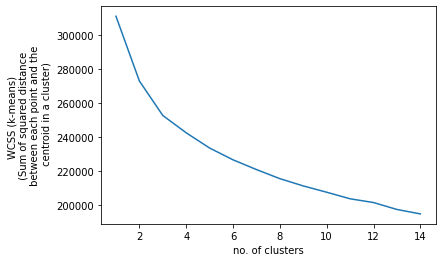

In [25]:
# Scree plot
plt.plot(k_candidates, wcss_kmeans)
plt.xlabel("no. of clusters")
plt.ylabel('WCSS (k-means) \n (Sum of squared distance \n between each point and the \n centroid in a cluster)')

The location of the elbow is ambiguous. I would say it is in the region $[3,6]$. I will choose it to be $4$.

**Optimal $k$ using Gap-Statistic:**

In [94]:
# Optimal K using GAP-stat

optimalK = OptimalK()

n_clusters = optimalK(X_train, cluster_array=k_candidates)
print('Optimal clusters: ', n_clusters)

Optimal clusters:  3


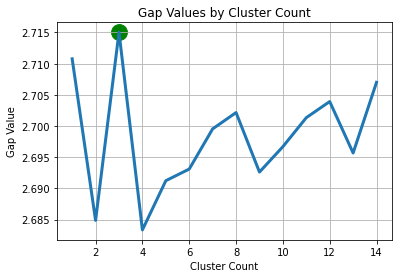

In [96]:
plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3)
plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='g')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

In [98]:
optimalK.gap_df.head(6)

,n_clusters,gap_value,gap*,ref_dispersion_std,sk,sk*,diff,diff*
0,1.0,2.710775,4.365737e+06,13004.994680,0.003214,5.041141e+06,0.053549,4.961888e+06
1,2.0,2.684873,3.843951e+06,99595.410067,0.027648,4.440101e+06,-0.029035,4.395853e+06
2,3.0,2.715035,3.567539e+06,3729.234836,0.001127,4.119441e+06,0.046693,4.095496e+06
3,4.0,2.683353,3.410278e+06,47732.013801,0.015010,3.938236e+06,-0.006134,3.913577e+06
4,5.0,2.691242,3.253341e+06,5307.886119,0.001756,3.756640e+06,0.003077,3.739989e+06
5,6.0,2.693106,3.145494e+06,14446.626971,0.004941,3.632142e+06,-0.001712,3.620790e+06


So the value of 3 clusters by the GAP statistic is not too different than the visually chosen one of 5 from the Scree Plot.

**Using Silhouette Statistic**

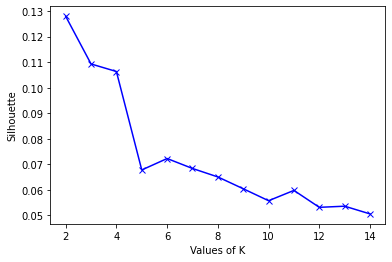

Max average silhouette score is : 0.12796  for n_clusters = 2
CPU times: user 1min 35s, sys: 23.8 s, total: 1min 59s
Wall time: 1min 17s


In [121]:
%%time
# >2 necessary to calculate Silhouette distances
silhouette_by_k=[]
K = range(2, 15)

for n_clusters in K:
    # Initialize the clusterer
    clusterer = KMeans(n_clusters=n_clusters, random_state=0)

    # Fit, Predict
    cluster_labels = clusterer.fit_predict(X_train)

    #Avg Silhouette Score
    silhouette_avg = silhouette_score(X_train, cluster_labels)
    silhouette_by_k.append(silhouette_avg)

# Plot Results
plt.plot(K, silhouette_by_k, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Silhouette') 
plt.show() 
    
print("Max average silhouette score is :", round(max(silhouette_by_k),5), 
      " for n_clusters =", K[silhouette_by_k.index(max(silhouette_by_k))])

### 3.1.2 $k=5$ Means Clustering

Add predicted labels from $k$=5 mean-clustering to dataset.

In [26]:
# Data
X = X_train

# Instantiate clusterer
k = 4
fourmean_clusterer = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)

# Fit
fourmean_clusterer.fit(X)

# Predict labels
fourmean_labels = fourmean_clusterer.predict(X)

Create dataset with predicted cluster labels, using $k$-means clustering, as column.

In [27]:
# Copy original df
X_kmeans_clustrd = X_train.copy()

# Add predicted cluster labels
X_kmeans_clustrd['kmeans_cluster'] = pd.Series(fourmean_labels, index = X_kmeans_clustrd.index)
X_kmeans_clustrd

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Diff,gender_M,admin_type_EMERGENCY,admin_type_URGENT,ins_Medicaid,ins_Medicare,ins_Private,ins_Self Pay,firstcare_CSRU,firstcare_MICU,firstcare_SICU,firstcare_TSICU,kmeans_cluster
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
92295,-0.121152,-0.677327,-0.534884,0.675057,-0.334557,0.609659,-0.287071,0.021940,0.086398,0.037469,-0.335269,0.129819,0.590701,-0.765860,-0.328615,-0.717840,0.303666,0.406066,0.269365,0.397473,0.670963,0.677407,-0.113520,0.267633,-0.959147,1,1,0,0,1,0,0,0,0,0,0,1
27002,-0.734550,-1.488229,-1.328842,-0.303656,-0.884276,-0.504762,0.383609,-0.661793,-0.037246,0.177313,-0.661588,-0.391616,-0.542477,-1.242651,-0.873260,0.569066,-0.481616,-0.183087,0.555068,0.397473,1.020671,-0.265600,0.184277,-0.058431,1.004644,1,1,0,0,0,1,0,0,1,0,0,1
55036,-0.530084,-0.915828,-0.638745,0.502343,-0.123127,0.407287,1.305793,0.021940,1.364054,0.946454,-0.190238,1.026835,-1.392361,-0.447999,-0.600703,0.971224,0.874781,0.820047,-0.159189,-0.487580,-0.788855,-0.083082,-0.124155,0.136523,0.721092,1,1,0,0,0,1,0,0,0,0,1,0
56112,-1.347948,2.804782,-0.538730,-0.015799,0.638021,-0.206433,0.467443,-0.504008,0.222636,0.736688,-0.045207,0.586736,0.590701,-1.242651,-0.233623,1.132087,-0.767174,0.142624,0.126514,0.397473,0.786362,-1.299864,2.481569,1.514882,-1.099693,0,1,0,0,1,0,0,0,1,0,0,2
55238,-1.484258,-0.963528,-1.403529,-0.246085,0.595735,-0.198430,0.886618,1.494596,1.414981,0.596844,1.223811,1.401791,1.723880,0.028792,1.563367,-5.431132,-0.553006,-3.936484,0.697920,0.397473,1.316661,-0.630634,-0.241147,-0.242147,-1.519931,0,1,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86270,-0.052997,-0.200326,0.379968,0.041772,-1.180278,-0.659786,0.467443,-0.609198,0.274673,0.317157,-0.697845,-0.160706,1.157291,0.664513,1.932432,-1.119998,-0.909953,-1.210512,-0.444892,-2.257686,-1.329301,-0.235180,-0.060342,-0.447362,-1.253321,1,1,0,0,0,1,0,0,1,0,0,3
55677,-1.484258,-0.295726,-0.446658,-0.821798,2.329463,-0.262715,-2.047604,-1.608500,-2.065887,-0.941437,-0.153980,-1.736672,-0.825772,-0.130139,-0.147697,1.775540,-0.196059,0.909002,0.269365,0.397473,0.168123,-1.664899,0.396989,-0.157846,0.596134,1,1,0,0,1,0,0,1,0,0,0,1
54193,-0.461929,-0.009525,-0.349717,-2.088369,-0.757418,-0.981672,-0.622411,-0.714388,-0.851722,-0.591828,-0.480299,-0.679089,2.007175,3.048468,1.235796,-1.666933,0.303666,-0.889249,-1.159149,0.397473,0.881142,-0.417697,0.843685,0.487756,-0.765276,1,1,0,0,1,0,0,0,0,1,0,3


Inspection of distribution of characteristics/features across the five clusters.

0         AxesSubplot(0.1,0.559091;0.363636x0.340909)
1    AxesSubplot(0.536364,0.559091;0.363636x0.340909)
2             AxesSubplot(0.1,0.15;0.363636x0.340909)
3        AxesSubplot(0.536364,0.15;0.363636x0.340909)
dtype: object

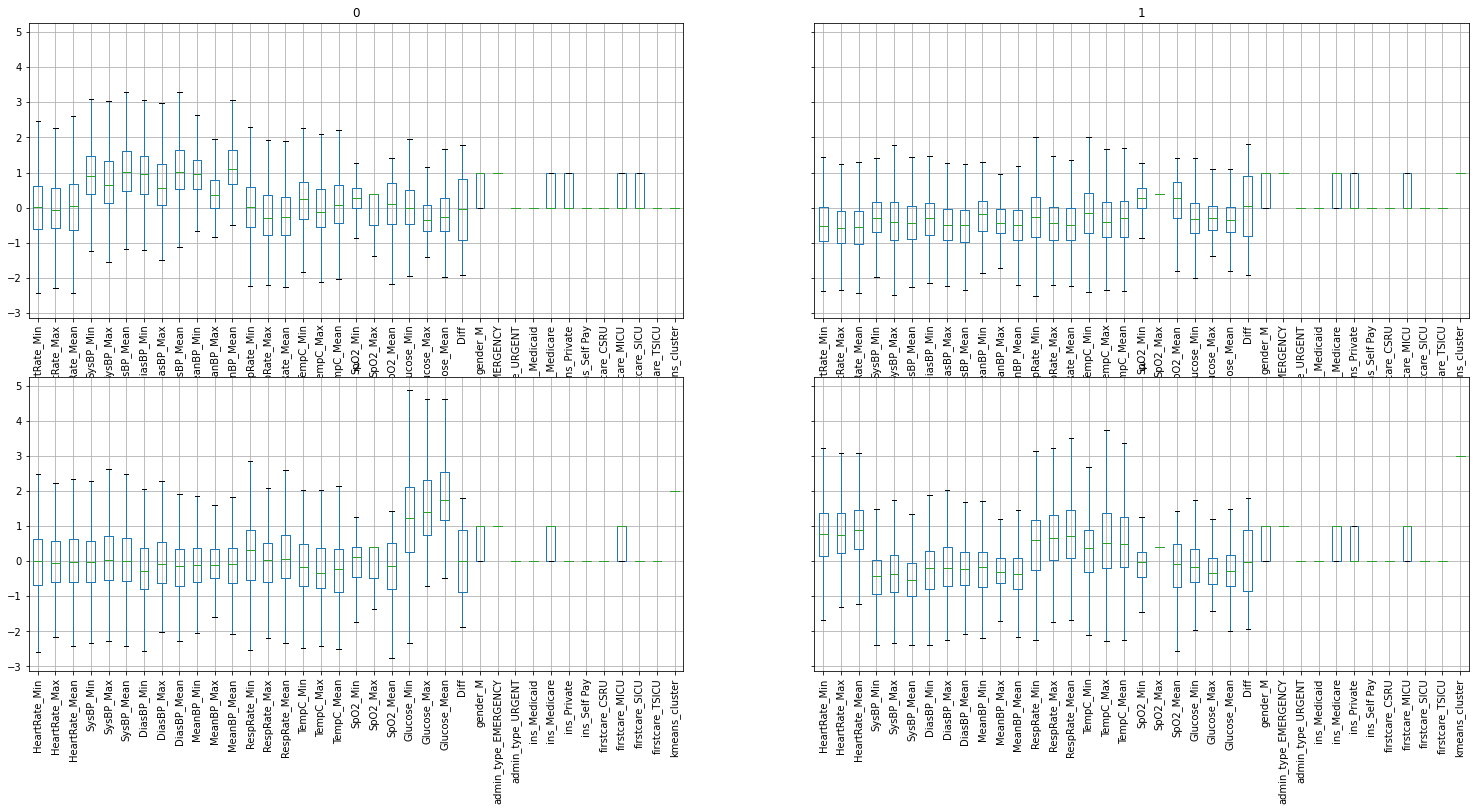

In [29]:
X_kmeans_clustrd.groupby('kmeans_cluster').boxplot(rot=90, figsize = [25,12], layout = (2, 2), showfliers=False )

In [56]:
# Predict labels on test
fourmean_lbls_test = fourmean_clusterer.predict(X_test)

# Copy test df
X_kmeans_clustrd_test = X_test.copy()

# Add predicted cluster labels to test
X_kmeans_clustrd_test['kmeans_cluster'] = pd.Series(fourmean_lbls_test, index = X_kmeans_clustrd_test.index)
X_kmeans_clustrd_test

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Diff,gender_M,admin_type_EMERGENCY,admin_type_URGENT,ins_Medicaid,ins_Medicare,ins_Private,ins_Self Pay,firstcare_CSRU,firstcare_MICU,firstcare_SICU,firstcare_TSICU,kmeans_cluster
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
76524,0.219624,-0.104926,0.356685,-0.533942,0.764879,0.671358,-2.215274,-1.292931,-1.149463,-0.871515,-0.480299,-0.476797,0.590701,1.618095,1.483969,0.729929,0.446445,0.493881,-0.302040,-0.487580,-1.380298,1.955028,1.205296,1.858047,0.543557,0,0,0,0,1,0,0,0,0,0,0,2
59020,-0.598239,-1.058928,-0.901602,0.041772,0.638021,0.170834,0.383609,1.179026,0.652051,0.177313,0.498657,0.370603,-0.259183,-0.924790,-0.549493,0.086476,-0.981342,-0.757870,0.555068,-0.487580,0.307428,-0.204760,-0.070977,-0.017388,1.056534,0,1,0,0,0,1,0,0,1,0,0,0
80187,0.015159,0.705977,1.017609,1.308342,0.172875,1.191508,0.802783,1.494596,1.612938,1.016376,0.716203,1.545468,0.307407,-0.447999,0.147154,-0.959135,-0.553006,-0.987783,-0.730595,0.397473,-1.355026,1.407476,0.258727,0.894678,-1.232113,0,1,0,0,1,0,0,0,1,0,0,0
75026,-1.007171,0.801377,-1.060895,-0.073371,-0.249985,-0.553172,-1.460760,-0.661793,-0.512131,-0.172296,-0.879134,-0.729430,0.024112,-1.401581,-1.015175,-0.154818,0.089498,-0.153477,0.126514,0.397473,-0.401763,-0.387278,-0.772928,-0.838247,0.928404,0,1,0,0,1,0,0,0,0,0,1,1
23161,-0.939016,-0.820428,-0.705421,-1.570226,-1.349422,-2.017841,-0.957750,-1.082552,-1.180344,-1.011359,-1.024164,-1.644521,1.157291,0.346652,0.995624,2.821151,0.732002,2.154366,-1.587703,-10.223163,-6.252588,2.837195,0.599066,1.840946,0.496289,1,1,0,0,1,0,0,0,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57449,1.787196,1.135278,1.623989,-0.015799,-0.292271,-0.556514,0.802783,-0.766983,0.142147,0.526922,-0.661588,-0.063098,2.290469,-0.447999,0.425242,1.132087,2.659515,2.310037,0.269365,0.397473,0.168123,-0.630634,-0.475131,-0.710558,1.730516,1,1,0,0,0,0,0,0,1,0,0,3
50328,-0.461929,-0.963528,-0.818201,-0.418799,-1.222564,-1.001113,-2.215274,-0.609198,-0.371211,-0.312140,-0.262753,-0.547230,-0.259183,-0.765860,-0.488688,0.890792,-0.481616,0.238421,-0.016337,-0.487580,-0.282830,0.707826,0.003472,0.294234,-1.024846,0,1,0,0,1,0,0,1,0,0,0,1
91121,2.605060,1.564579,2.048389,-0.821798,-0.630560,-1.186895,-0.957750,-0.766983,-0.905392,-0.591828,-0.190238,-0.920540,0.590701,0.505582,0.402649,4.108057,1.945621,3.735020,-5.016138,0.397473,-3.187870,0.738246,0.311905,0.746467,-1.678199,0,1,0,0,1,0,0,0,1,0,0,3


## 3.2 $k$-Medoids

### 3.2.1 Optimal $k$ Search

In [30]:
%%time
# Estimate k-medoids for n clusters and save the inertia/within-cluster sum-of-squares
k_candidates = range(1, 15)

wcss_med = []
for i in k_candidates:
    kmediods = KMedoids(n_clusters=i, 
                        init='k-medoids++', 
                        max_iter=300, 
                        random_state=0)
    kmediods.fit(X_train) 
    wcss_med.append(kmediods.inertia_)

CPU times: user 1min 8s, sys: 5.14 s, total: 1min 14s
Wall time: 1min 11s


Text(0, 0.5, 'WCSS (k-medioids) \n (Sum of squared distance \n between each point and the \n centroid in a cluster)')

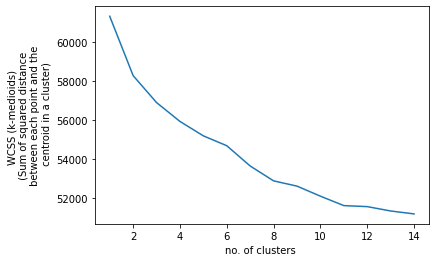

In [31]:
# Scree plot
plt.plot(k_candidates, wcss_med)
plt.xlabel("no. of clusters ")
plt.ylabel('WCSS (k-medioids) \n (Sum of squared distance \n between each point and the \n centroid in a cluster)')

The location of the elbow is ambiguous. I would say it is in the region $[3, 7]$. I will choose it to be $6$.

### 3.2.2 $k=6$ Medoid Clustering

Add predicted labels from $k$=6 medioid-clustering to dataset.

In [60]:
%%time
# Data
X = X_train

# Instantiate clusterer
k = 6
sixmean_kmed_clusterer = KMedoids(n_clusters=k, 
                        init='k-medoids++', 
                        max_iter=300, 
                        random_state=0)

# Fit
sixmean_kmed_clusterer.fit(X)

# Predict
sixmean_kmed_lbls = sixmean_kmed_clusterer.predict(X)

CPU times: user 5.79 s, sys: 62.6 ms, total: 5.85 s
Wall time: 6.74 s


Create dataset with predicted cluster labels, using $k$-medioids clustering, as column.

In [62]:
# Copy original df
X_kmed_clustrd = X_train.copy()

# Add predicted cluster labels
X_kmed_clustrd['kmed_cluster'] = pd.Series(sixmean_kmed_lbls, index = X_kmed_clustrd.index)
X_kmed_clustrd

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Diff,gender_M,admin_type_EMERGENCY,admin_type_URGENT,ins_Medicaid,ins_Medicare,ins_Private,ins_Self Pay,firstcare_CSRU,firstcare_MICU,firstcare_SICU,firstcare_TSICU,kmed_cluster
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
92295,-0.121152,-0.677327,-0.534884,0.675057,-0.334557,0.609659,-0.287071,0.021940,0.086398,0.037469,-0.335269,0.129819,0.590701,-0.765860,-0.328615,-0.717840,0.303666,0.406066,0.269365,0.397473,0.670963,0.677407,-0.113520,0.267633,-0.959147,1,1,0,0,1,0,0,0,0,0,0,1
27002,-0.734550,-1.488229,-1.328842,-0.303656,-0.884276,-0.504762,0.383609,-0.661793,-0.037246,0.177313,-0.661588,-0.391616,-0.542477,-1.242651,-0.873260,0.569066,-0.481616,-0.183087,0.555068,0.397473,1.020671,-0.265600,0.184277,-0.058431,1.004644,1,1,0,0,0,1,0,0,1,0,0,4
55036,-0.530084,-0.915828,-0.638745,0.502343,-0.123127,0.407287,1.305793,0.021940,1.364054,0.946454,-0.190238,1.026835,-1.392361,-0.447999,-0.600703,0.971224,0.874781,0.820047,-0.159189,-0.487580,-0.788855,-0.083082,-0.124155,0.136523,0.721092,1,1,0,0,0,1,0,0,0,0,1,1
56112,-1.347948,2.804782,-0.538730,-0.015799,0.638021,-0.206433,0.467443,-0.504008,0.222636,0.736688,-0.045207,0.586736,0.590701,-1.242651,-0.233623,1.132087,-0.767174,0.142624,0.126514,0.397473,0.786362,-1.299864,2.481569,1.514882,-1.099693,0,1,0,0,1,0,0,0,1,0,0,1
55238,-1.484258,-0.963528,-1.403529,-0.246085,0.595735,-0.198430,0.886618,1.494596,1.414981,0.596844,1.223811,1.401791,1.723880,0.028792,1.563367,-5.431132,-0.553006,-3.936484,0.697920,0.397473,1.316661,-0.630634,-0.241147,-0.242147,-1.519931,0,1,0,0,0,1,0,0,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86270,-0.052997,-0.200326,0.379968,0.041772,-1.180278,-0.659786,0.467443,-0.609198,0.274673,0.317157,-0.697845,-0.160706,1.157291,0.664513,1.932432,-1.119998,-0.909953,-1.210512,-0.444892,-2.257686,-1.329301,-0.235180,-0.060342,-0.447362,-1.253321,1,1,0,0,0,1,0,0,1,0,0,5
55677,-1.484258,-0.295726,-0.446658,-0.821798,2.329463,-0.262715,-2.047604,-1.608500,-2.065887,-0.941437,-0.153980,-1.736672,-0.825772,-0.130139,-0.147697,1.775540,-0.196059,0.909002,0.269365,0.397473,0.168123,-1.664899,0.396989,-0.157846,0.596134,1,1,0,0,1,0,0,1,0,0,0,4
54193,-0.461929,-0.009525,-0.349717,-2.088369,-0.757418,-0.981672,-0.622411,-0.714388,-0.851722,-0.591828,-0.480299,-0.679089,2.007175,3.048468,1.235796,-1.666933,0.303666,-0.889249,-1.159149,0.397473,0.881142,-0.417697,0.843685,0.487756,-0.765276,1,1,0,0,1,0,0,0,0,1,0,5


In [63]:
X_kmed_clustrd['kmed_cluster'].value_counts()

1    4055
4    2600
2    1820
0    1213
3    1122
5     898
Name: kmed_cluster, dtype: int64

Inspection of distribution of characteristics/features across the five clusters.

0         AxesSubplot(0.1,0.559091;0.235294x0.340909)
1    AxesSubplot(0.382353,0.559091;0.235294x0.340909)
2    AxesSubplot(0.664706,0.559091;0.235294x0.340909)
3             AxesSubplot(0.1,0.15;0.235294x0.340909)
4        AxesSubplot(0.382353,0.15;0.235294x0.340909)
5        AxesSubplot(0.664706,0.15;0.235294x0.340909)
dtype: object

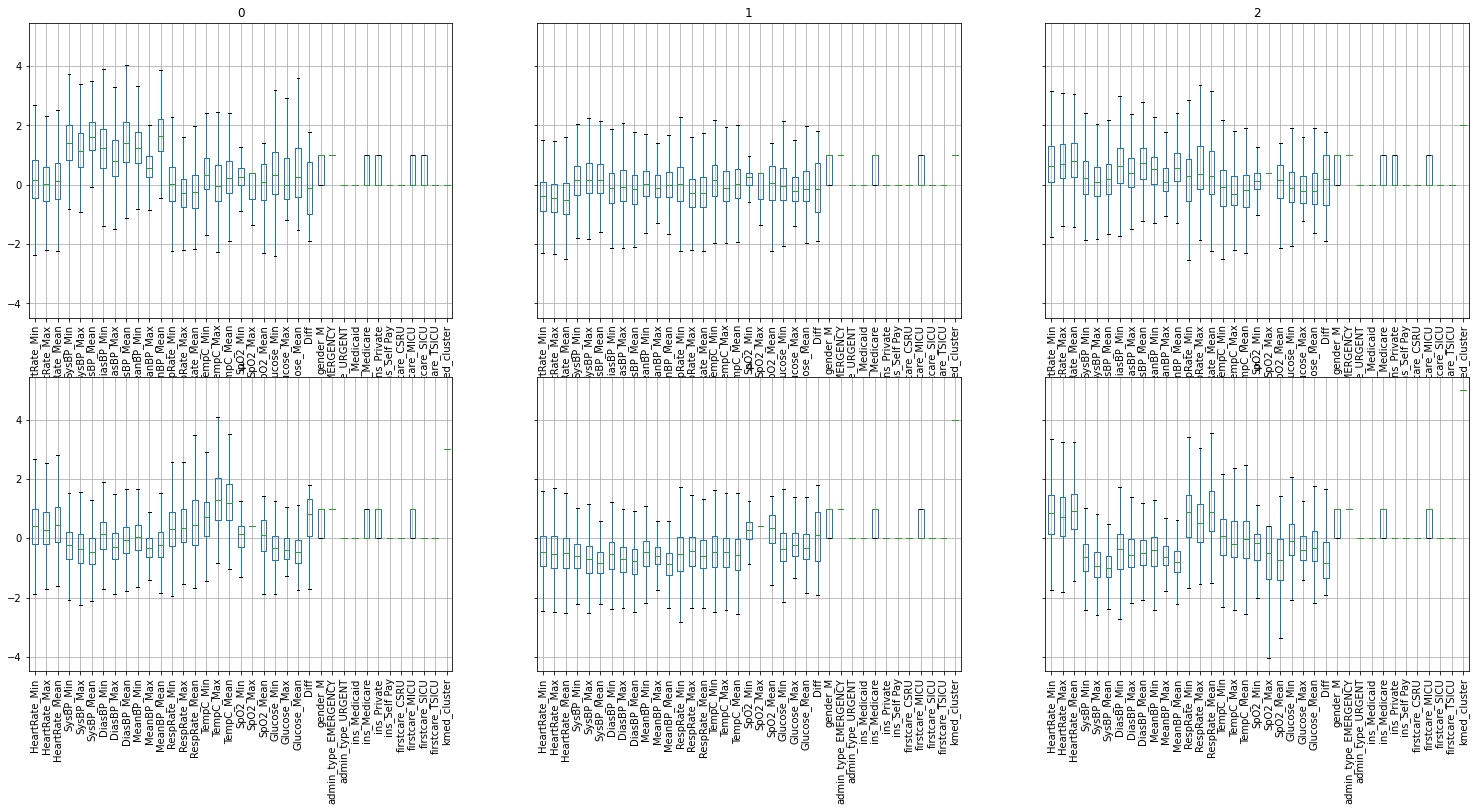

In [64]:
X_kmed_clustrd.groupby('kmed_cluster').boxplot(rot=90, figsize = [25,12], layout = (2, 3), showfliers=False )

In [68]:
# Predict labels on test
sixmean_kmed_lbls_test = sixmean_kmed_clusterer.predict(X_test)

# Copy test df
X_kmed_clustrd_test = X_test.copy()

# Add predicted cluster labels to test
X_kmed_clustrd_test['kmed_cluster'] = pd.Series(sixmean_kmed_lbls_test, index = X_kmed_clustrd_test.index)
X_kmed_clustrd_test

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Diff,gender_M,admin_type_EMERGENCY,admin_type_URGENT,ins_Medicaid,ins_Medicare,ins_Private,ins_Self Pay,firstcare_CSRU,firstcare_MICU,firstcare_SICU,firstcare_TSICU,kmed_cluster
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
76524,0.219624,-0.104926,0.356685,-0.533942,0.764879,0.671358,-2.215274,-1.292931,-1.149463,-0.871515,-0.480299,-0.476797,0.590701,1.618095,1.483969,0.729929,0.446445,0.493881,-0.302040,-0.487580,-1.380298,1.955028,1.205296,1.858047,0.543557,0,0,0,0,1,0,0,0,0,0,0,1
59020,-0.598239,-1.058928,-0.901602,0.041772,0.638021,0.170834,0.383609,1.179026,0.652051,0.177313,0.498657,0.370603,-0.259183,-0.924790,-0.549493,0.086476,-0.981342,-0.757870,0.555068,-0.487580,0.307428,-0.204760,-0.070977,-0.017388,1.056534,0,1,0,0,0,1,0,0,1,0,0,1
80187,0.015159,0.705977,1.017609,1.308342,0.172875,1.191508,0.802783,1.494596,1.612938,1.016376,0.716203,1.545468,0.307407,-0.447999,0.147154,-0.959135,-0.553006,-0.987783,-0.730595,0.397473,-1.355026,1.407476,0.258727,0.894678,-1.232113,0,1,0,0,1,0,0,0,1,0,0,0
75026,-1.007171,0.801377,-1.060895,-0.073371,-0.249985,-0.553172,-1.460760,-0.661793,-0.512131,-0.172296,-0.879134,-0.729430,0.024112,-1.401581,-1.015175,-0.154818,0.089498,-0.153477,0.126514,0.397473,-0.401763,-0.387278,-0.772928,-0.838247,0.928404,0,1,0,0,1,0,0,0,0,0,1,4
23161,-0.939016,-0.820428,-0.705421,-1.570226,-1.349422,-2.017841,-0.957750,-1.082552,-1.180344,-1.011359,-1.024164,-1.644521,1.157291,0.346652,0.995624,2.821151,0.732002,2.154366,-1.587703,-10.223163,-6.252588,2.837195,0.599066,1.840946,0.496289,1,1,0,0,1,0,0,0,1,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57449,1.787196,1.135278,1.623989,-0.015799,-0.292271,-0.556514,0.802783,-0.766983,0.142147,0.526922,-0.661588,-0.063098,2.290469,-0.447999,0.425242,1.132087,2.659515,2.310037,0.269365,0.397473,0.168123,-0.630634,-0.475131,-0.710558,1.730516,1,1,0,0,0,0,0,0,1,0,0,3
50328,-0.461929,-0.963528,-0.818201,-0.418799,-1.222564,-1.001113,-2.215274,-0.609198,-0.371211,-0.312140,-0.262753,-0.547230,-0.259183,-0.765860,-0.488688,0.890792,-0.481616,0.238421,-0.016337,-0.487580,-0.282830,0.707826,0.003472,0.294234,-1.024846,0,1,0,0,1,0,0,1,0,0,0,1
91121,2.605060,1.564579,2.048389,-0.821798,-0.630560,-1.186895,-0.957750,-0.766983,-0.905392,-0.591828,-0.190238,-0.920540,0.590701,0.505582,0.402649,4.108057,1.945621,3.735020,-5.016138,0.397473,-3.187870,0.738246,0.311905,0.746467,-1.678199,0,1,0,0,1,0,0,0,1,0,0,5


## 3.3 Affinity Propagation 

In [45]:
%%time
from sklearn.cluster import AffinityPropagation

# Data
X = X_train

# Instantiate
af = AffinityPropagation()

# Fit 
af.fit(X)

# Predict labels
af_lbls = fourmean_clusterer.predict(X)
af_lbls

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_affinity_propagation.py:253: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  ConvergenceWarning,


array([1, 1, 0, ..., 3, 0, 2], dtype=int32)

1    4783
0    2915
3    2753
2    1257
dtype: int64


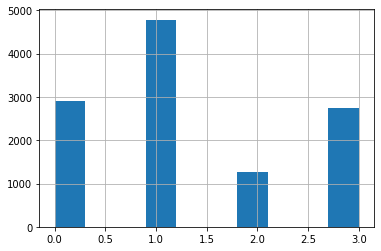

In [70]:
print(pd.Series(af_lbls).value_counts())
pd.Series(af_lbls).hist()

In [71]:
# Copy original df
X_af_clustrd = X_train.copy()

# Add predicted cluster labels
X_af_clustrd['af_cluster'] = pd.Series(af_lbls, index = X_af_clustrd.index)
X_af_clustrd

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Diff,gender_M,admin_type_EMERGENCY,admin_type_URGENT,ins_Medicaid,ins_Medicare,ins_Private,ins_Self Pay,firstcare_CSRU,firstcare_MICU,firstcare_SICU,firstcare_TSICU,af_cluster
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
92295,-0.121152,-0.677327,-0.534884,0.675057,-0.334557,0.609659,-0.287071,0.021940,0.086398,0.037469,-0.335269,0.129819,0.590701,-0.765860,-0.328615,-0.717840,0.303666,0.406066,0.269365,0.397473,0.670963,0.677407,-0.113520,0.267633,-0.959147,1,1,0,0,1,0,0,0,0,0,0,1
27002,-0.734550,-1.488229,-1.328842,-0.303656,-0.884276,-0.504762,0.383609,-0.661793,-0.037246,0.177313,-0.661588,-0.391616,-0.542477,-1.242651,-0.873260,0.569066,-0.481616,-0.183087,0.555068,0.397473,1.020671,-0.265600,0.184277,-0.058431,1.004644,1,1,0,0,0,1,0,0,1,0,0,1
55036,-0.530084,-0.915828,-0.638745,0.502343,-0.123127,0.407287,1.305793,0.021940,1.364054,0.946454,-0.190238,1.026835,-1.392361,-0.447999,-0.600703,0.971224,0.874781,0.820047,-0.159189,-0.487580,-0.788855,-0.083082,-0.124155,0.136523,0.721092,1,1,0,0,0,1,0,0,0,0,1,0
56112,-1.347948,2.804782,-0.538730,-0.015799,0.638021,-0.206433,0.467443,-0.504008,0.222636,0.736688,-0.045207,0.586736,0.590701,-1.242651,-0.233623,1.132087,-0.767174,0.142624,0.126514,0.397473,0.786362,-1.299864,2.481569,1.514882,-1.099693,0,1,0,0,1,0,0,0,1,0,0,2
55238,-1.484258,-0.963528,-1.403529,-0.246085,0.595735,-0.198430,0.886618,1.494596,1.414981,0.596844,1.223811,1.401791,1.723880,0.028792,1.563367,-5.431132,-0.553006,-3.936484,0.697920,0.397473,1.316661,-0.630634,-0.241147,-0.242147,-1.519931,0,1,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86270,-0.052997,-0.200326,0.379968,0.041772,-1.180278,-0.659786,0.467443,-0.609198,0.274673,0.317157,-0.697845,-0.160706,1.157291,0.664513,1.932432,-1.119998,-0.909953,-1.210512,-0.444892,-2.257686,-1.329301,-0.235180,-0.060342,-0.447362,-1.253321,1,1,0,0,0,1,0,0,1,0,0,3
55677,-1.484258,-0.295726,-0.446658,-0.821798,2.329463,-0.262715,-2.047604,-1.608500,-2.065887,-0.941437,-0.153980,-1.736672,-0.825772,-0.130139,-0.147697,1.775540,-0.196059,0.909002,0.269365,0.397473,0.168123,-1.664899,0.396989,-0.157846,0.596134,1,1,0,0,1,0,0,1,0,0,0,1
54193,-0.461929,-0.009525,-0.349717,-2.088369,-0.757418,-0.981672,-0.622411,-0.714388,-0.851722,-0.591828,-0.480299,-0.679089,2.007175,3.048468,1.235796,-1.666933,0.303666,-0.889249,-1.159149,0.397473,0.881142,-0.417697,0.843685,0.487756,-0.765276,1,1,0,0,1,0,0,0,0,1,0,3


In [69]:
# Predict labels on test
af_lbls_test = af.predict(X_test)

# Copy test df
X_af_clustrd_test = X_test.copy()

# Add predicted cluster labels to test
X_af_clustrd_test['af_cluster'] = pd.Series(af_lbls_test, index = X_af_clustrd_test.index)
X_af_clustrd_test

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_affinity_propagation.py:532: ConvergenceWarning: This model does not have any cluster centers because affinity propagation did not converge. Labeling every sample as '-1'.
  ConvergenceWarning,


,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Diff,gender_M,admin_type_EMERGENCY,admin_type_URGENT,ins_Medicaid,ins_Medicare,ins_Private,ins_Self Pay,firstcare_CSRU,firstcare_MICU,firstcare_SICU,firstcare_TSICU,af_cluster
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
76524,0.219624,-0.104926,0.356685,-0.533942,0.764879,0.671358,-2.215274,-1.292931,-1.149463,-0.871515,-0.480299,-0.476797,0.590701,1.618095,1.483969,0.729929,0.446445,0.493881,-0.302040,-0.487580,-1.380298,1.955028,1.205296,1.858047,0.543557,0,0,0,0,1,0,0,0,0,0,0,-1
59020,-0.598239,-1.058928,-0.901602,0.041772,0.638021,0.170834,0.383609,1.179026,0.652051,0.177313,0.498657,0.370603,-0.259183,-0.924790,-0.549493,0.086476,-0.981342,-0.757870,0.555068,-0.487580,0.307428,-0.204760,-0.070977,-0.017388,1.056534,0,1,0,0,0,1,0,0,1,0,0,-1
80187,0.015159,0.705977,1.017609,1.308342,0.172875,1.191508,0.802783,1.494596,1.612938,1.016376,0.716203,1.545468,0.307407,-0.447999,0.147154,-0.959135,-0.553006,-0.987783,-0.730595,0.397473,-1.355026,1.407476,0.258727,0.894678,-1.232113,0,1,0,0,1,0,0,0,1,0,0,-1
75026,-1.007171,0.801377,-1.060895,-0.073371,-0.249985,-0.553172,-1.460760,-0.661793,-0.512131,-0.172296,-0.879134,-0.729430,0.024112,-1.401581,-1.015175,-0.154818,0.089498,-0.153477,0.126514,0.397473,-0.401763,-0.387278,-0.772928,-0.838247,0.928404,0,1,0,0,1,0,0,0,0,0,1,-1
23161,-0.939016,-0.820428,-0.705421,-1.570226,-1.349422,-2.017841,-0.957750,-1.082552,-1.180344,-1.011359,-1.024164,-1.644521,1.157291,0.346652,0.995624,2.821151,0.732002,2.154366,-1.587703,-10.223163,-6.252588,2.837195,0.599066,1.840946,0.496289,1,1,0,0,1,0,0,0,1,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57449,1.787196,1.135278,1.623989,-0.015799,-0.292271,-0.556514,0.802783,-0.766983,0.142147,0.526922,-0.661588,-0.063098,2.290469,-0.447999,0.425242,1.132087,2.659515,2.310037,0.269365,0.397473,0.168123,-0.630634,-0.475131,-0.710558,1.730516,1,1,0,0,0,0,0,0,1,0,0,-1
50328,-0.461929,-0.963528,-0.818201,-0.418799,-1.222564,-1.001113,-2.215274,-0.609198,-0.371211,-0.312140,-0.262753,-0.547230,-0.259183,-0.765860,-0.488688,0.890792,-0.481616,0.238421,-0.016337,-0.487580,-0.282830,0.707826,0.003472,0.294234,-1.024846,0,1,0,0,1,0,0,1,0,0,0,-1
91121,2.605060,1.564579,2.048389,-0.821798,-0.630560,-1.186895,-0.957750,-0.766983,-0.905392,-0.591828,-0.190238,-0.920540,0.590701,0.505582,0.402649,4.108057,1.945621,3.735020,-5.016138,0.397473,-3.187870,0.738246,0.311905,0.746467,-1.678199,0,1,0,0,1,0,0,0,1,0,0,-1


-1    5768
dtype: int64


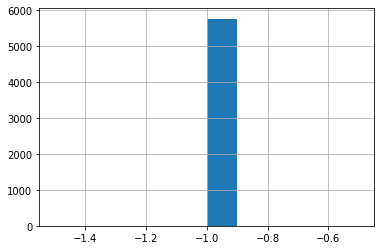

In [72]:
print(pd.Series(af_lbls_test).value_counts())
pd.Series(af_lbls_test).hist()

## 3.4 Mean-Shift

In [75]:
%%time
# Data 
X = X_train

# Estimate Bandwidth
bandwidth = estimate_bandwidth(X, quantile=0.3)
print(bandwidth)

# Instantiate
mshift = MeanShift(bandwidth=bandwidth)

# Fit
mshift.fit(X)

# Predict
mshift_lbls = mshift.predict(X)

6.0739807792260425
CPU times: user 4min, sys: 3min 22s, total: 7min 23s
Wall time: 3min 52s


In [76]:
np.unique(mshift.labels_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84])

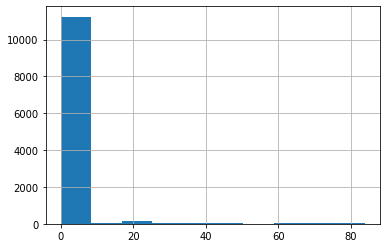

In [77]:
pd.Series(mshift_lbls).hist()

Create dataset with predicted cluster labels, using mean-shift clustering, as column.

In [78]:
# Copy original df
X_mshift_clustrd = X_train.copy()

# Add predicted cluster labels
X_mshift_clustrd['mshift_cluster'] = pd.Series(mshift_lbls, index = X_mshift_clustrd.index)
X_mshift_clustrd

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Diff,gender_M,admin_type_EMERGENCY,admin_type_URGENT,ins_Medicaid,ins_Medicare,ins_Private,ins_Self Pay,firstcare_CSRU,firstcare_MICU,firstcare_SICU,firstcare_TSICU,mshift_cluster
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
92295,-0.121152,-0.677327,-0.534884,0.675057,-0.334557,0.609659,-0.287071,0.021940,0.086398,0.037469,-0.335269,0.129819,0.590701,-0.765860,-0.328615,-0.717840,0.303666,0.406066,0.269365,0.397473,0.670963,0.677407,-0.113520,0.267633,-0.959147,1,1,0,0,1,0,0,0,0,0,0,0
27002,-0.734550,-1.488229,-1.328842,-0.303656,-0.884276,-0.504762,0.383609,-0.661793,-0.037246,0.177313,-0.661588,-0.391616,-0.542477,-1.242651,-0.873260,0.569066,-0.481616,-0.183087,0.555068,0.397473,1.020671,-0.265600,0.184277,-0.058431,1.004644,1,1,0,0,0,1,0,0,1,0,0,0
55036,-0.530084,-0.915828,-0.638745,0.502343,-0.123127,0.407287,1.305793,0.021940,1.364054,0.946454,-0.190238,1.026835,-1.392361,-0.447999,-0.600703,0.971224,0.874781,0.820047,-0.159189,-0.487580,-0.788855,-0.083082,-0.124155,0.136523,0.721092,1,1,0,0,0,1,0,0,0,0,1,0
56112,-1.347948,2.804782,-0.538730,-0.015799,0.638021,-0.206433,0.467443,-0.504008,0.222636,0.736688,-0.045207,0.586736,0.590701,-1.242651,-0.233623,1.132087,-0.767174,0.142624,0.126514,0.397473,0.786362,-1.299864,2.481569,1.514882,-1.099693,0,1,0,0,1,0,0,0,1,0,0,0
55238,-1.484258,-0.963528,-1.403529,-0.246085,0.595735,-0.198430,0.886618,1.494596,1.414981,0.596844,1.223811,1.401791,1.723880,0.028792,1.563367,-5.431132,-0.553006,-3.936484,0.697920,0.397473,1.316661,-0.630634,-0.241147,-0.242147,-1.519931,0,1,0,0,0,1,0,0,1,0,0,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86270,-0.052997,-0.200326,0.379968,0.041772,-1.180278,-0.659786,0.467443,-0.609198,0.274673,0.317157,-0.697845,-0.160706,1.157291,0.664513,1.932432,-1.119998,-0.909953,-1.210512,-0.444892,-2.257686,-1.329301,-0.235180,-0.060342,-0.447362,-1.253321,1,1,0,0,0,1,0,0,1,0,0,0
55677,-1.484258,-0.295726,-0.446658,-0.821798,2.329463,-0.262715,-2.047604,-1.608500,-2.065887,-0.941437,-0.153980,-1.736672,-0.825772,-0.130139,-0.147697,1.775540,-0.196059,0.909002,0.269365,0.397473,0.168123,-1.664899,0.396989,-0.157846,0.596134,1,1,0,0,1,0,0,1,0,0,0,0
54193,-0.461929,-0.009525,-0.349717,-2.088369,-0.757418,-0.981672,-0.622411,-0.714388,-0.851722,-0.591828,-0.480299,-0.679089,2.007175,3.048468,1.235796,-1.666933,0.303666,-0.889249,-1.159149,0.397473,0.881142,-0.417697,0.843685,0.487756,-0.765276,1,1,0,0,1,0,0,0,0,1,0,0


In [79]:
# Predict labels on test
mshift_lbls_test = mshift.predict(X_test)

# Copy test df
X_mshift_clustrd_test = X_test.copy()

# Add predicted cluster labels to test
X_mshift_clustrd_test['mshift_cluster'] = pd.Series(af_lbls_test, index = X_mshift_clustrd_test.index)
X_mshift_clustrd_test

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Diff,gender_M,admin_type_EMERGENCY,admin_type_URGENT,ins_Medicaid,ins_Medicare,ins_Private,ins_Self Pay,firstcare_CSRU,firstcare_MICU,firstcare_SICU,firstcare_TSICU,mshift_cluster
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
76524,0.219624,-0.104926,0.356685,-0.533942,0.764879,0.671358,-2.215274,-1.292931,-1.149463,-0.871515,-0.480299,-0.476797,0.590701,1.618095,1.483969,0.729929,0.446445,0.493881,-0.302040,-0.487580,-1.380298,1.955028,1.205296,1.858047,0.543557,0,0,0,0,1,0,0,0,0,0,0,-1
59020,-0.598239,-1.058928,-0.901602,0.041772,0.638021,0.170834,0.383609,1.179026,0.652051,0.177313,0.498657,0.370603,-0.259183,-0.924790,-0.549493,0.086476,-0.981342,-0.757870,0.555068,-0.487580,0.307428,-0.204760,-0.070977,-0.017388,1.056534,0,1,0,0,0,1,0,0,1,0,0,-1
80187,0.015159,0.705977,1.017609,1.308342,0.172875,1.191508,0.802783,1.494596,1.612938,1.016376,0.716203,1.545468,0.307407,-0.447999,0.147154,-0.959135,-0.553006,-0.987783,-0.730595,0.397473,-1.355026,1.407476,0.258727,0.894678,-1.232113,0,1,0,0,1,0,0,0,1,0,0,-1
75026,-1.007171,0.801377,-1.060895,-0.073371,-0.249985,-0.553172,-1.460760,-0.661793,-0.512131,-0.172296,-0.879134,-0.729430,0.024112,-1.401581,-1.015175,-0.154818,0.089498,-0.153477,0.126514,0.397473,-0.401763,-0.387278,-0.772928,-0.838247,0.928404,0,1,0,0,1,0,0,0,0,0,1,-1
23161,-0.939016,-0.820428,-0.705421,-1.570226,-1.349422,-2.017841,-0.957750,-1.082552,-1.180344,-1.011359,-1.024164,-1.644521,1.157291,0.346652,0.995624,2.821151,0.732002,2.154366,-1.587703,-10.223163,-6.252588,2.837195,0.599066,1.840946,0.496289,1,1,0,0,1,0,0,0,1,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57449,1.787196,1.135278,1.623989,-0.015799,-0.292271,-0.556514,0.802783,-0.766983,0.142147,0.526922,-0.661588,-0.063098,2.290469,-0.447999,0.425242,1.132087,2.659515,2.310037,0.269365,0.397473,0.168123,-0.630634,-0.475131,-0.710558,1.730516,1,1,0,0,0,0,0,0,1,0,0,-1
50328,-0.461929,-0.963528,-0.818201,-0.418799,-1.222564,-1.001113,-2.215274,-0.609198,-0.371211,-0.312140,-0.262753,-0.547230,-0.259183,-0.765860,-0.488688,0.890792,-0.481616,0.238421,-0.016337,-0.487580,-0.282830,0.707826,0.003472,0.294234,-1.024846,0,1,0,0,1,0,0,1,0,0,0,-1
91121,2.605060,1.564579,2.048389,-0.821798,-0.630560,-1.186895,-0.957750,-0.766983,-0.905392,-0.591828,-0.190238,-0.920540,0.590701,0.505582,0.402649,4.108057,1.945621,3.735020,-5.016138,0.397473,-3.187870,0.738246,0.311905,0.746467,-1.678199,0,1,0,0,1,0,0,0,1,0,0,-1


In [81]:
X_mshift_clustrd_test['mshift_cluster'].value_counts()

-1    5768
Name: mshift_cluster, dtype: int64

## 3.5 Spectral Clustering

NB: Just as in the case with Affinity Propagation, the Spectral Clustering Algorithm cannot handle the dataset. It works for restricted sample (first 5,000 out of 17,000 rows) but crashes at the first 10,000 rows.
<br>

Code is left below to show my intention

In [52]:
print(k)

6


In [82]:
%%script echo skipping
# Data
X = X_train
#X = X_train.iloc[0:10000,:]

# Instantiate
spectral_clusterer = SpectralClustering(n_clusters=k, 
        assign_labels="discretize",
        random_state=0)

# Fit
spec_labels = spectral_clusterer.fit_predict(X)

skipping


In [ ]:
pd.Series(spec_labels).value_counts()
#spec_labels.shape
#spec_labels

0    4973
1      12
3      10
4       3
2       2
dtype: int64

Create dataset with predicted cluster labels, using spectral clustering, as column.

In [ ]:
# Copy original df
X_spec_clustrd = X_train.copy()

# Add predicted cluster labels
X_spec_clustrd['spec_cluster'] = pd.Series(spec_labels, index = X_spec_clustrd.index)
X_spec_clustrd

# **4. SVD Analysis**

Analysis is extended by using Single Value Decomposition (SVD)

## 4.0 Decomposing Data with SVD

In [83]:
u, s, v = np.linalg.svd(X_train, full_matrices = True) #Run time: 10s

In [85]:
print(X_train.shape)
print(u.shape)
print(s.shape)
print(v.shape)

(11708, 36)
(11708, 11708)
(36,)
(36, 36)


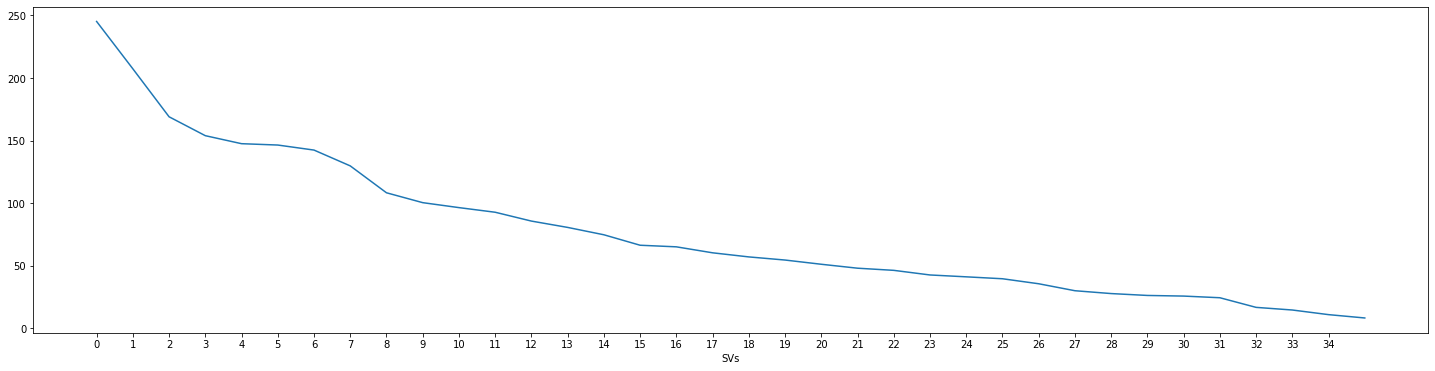

In [90]:
# Plot the single values
plt.plot(s)
plt.xlabel("SVs")
plt.xticks(np.arange(0, 35, step=1))
plt.gcf().set_size_inches(25, 6)

The elbow is decided to be at $SV=4$.

In [91]:
labels= ['SV'+str(i) for i in range(1,5)]
svd_df = pd.DataFrame(u[:,0:4], columns = labels)
svd_df

,SV1,SV2,SV3,SV4
0,-0.001039,-0.004389,0.000722,-0.002173
1,0.003951,-0.011840,-0.004893,-0.000385
2,-0.008106,-0.004888,-0.003960,0.003186
3,-0.003231,-0.000277,0.003961,-0.010310
4,-0.004905,-0.012820,0.020003,0.013910
...,...,...,...,...
11703,0.003262,0.005013,0.012073,0.021183
11704,0.011138,-0.003469,-0.006004,-0.007065
11705,0.011616,0.008694,0.010633,0.002309
11706,-0.008398,-0.001990,-0.007639,-0.002491


## 4.1 $k$-Means Clustering

### 4.1.1 Optimal $k$ Search

### 4.1.2 $k=?$ Means Clustering

Add predicted labels from $k$=5 mean-clustering to dataset.

## 4.2 $k$-Medoids

### 4.2.1 Optimal $k$ Search

### 4.2.2 $k=?$ Medoid Clustering

Add predicted labels from $k$=6 medioid-clustering to dataset.

## 4.3 Affinity Propagation 

## 4.4 Mean-Shift

## 4.5 Spectral Clustering

# **Response Variables**

2 (separate) goals:


*   Predict mortality: `HOSPITAL_EXPIRE_FLAG` (binary classification problem)
*   Predict length of stay: `LOS` (continuous regression prediction problem)



In [99]:
target

,HOSPITAL_EXPIRE_FLAG,LOS
subject_id,,
55440,0,4.5761
76908,0,0.7582
95798,0,3.7626
40708,0,3.8734
63311,0,1.8490
...,...,...
28043,0,11.6116
87605,0,1.1593
47492,0,1.8830
